In [36]:
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from utilities.visualisation import DataFrameVisualization, PatchesAndDataframeVisualization

In [37]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%%html
<style>

div.output_scroll {
    height : auto;
}
</style>

<IPython.core.display.Javascript object>


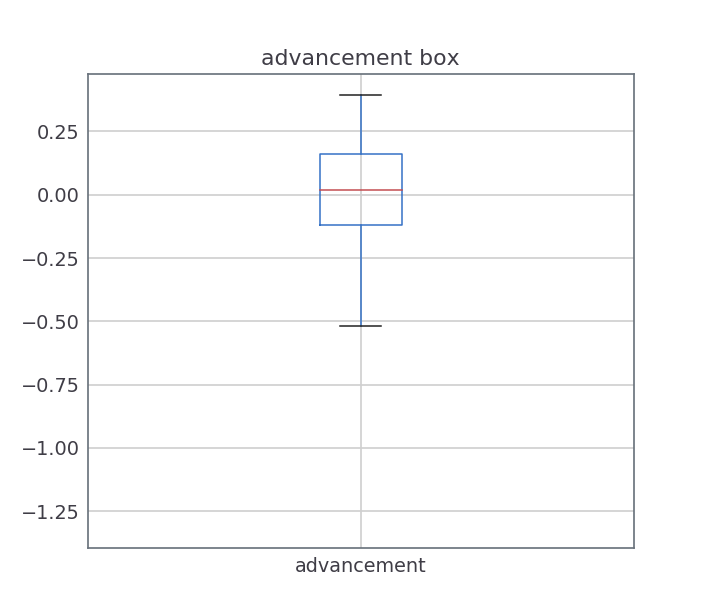

<IPython.core.display.Javascript object>


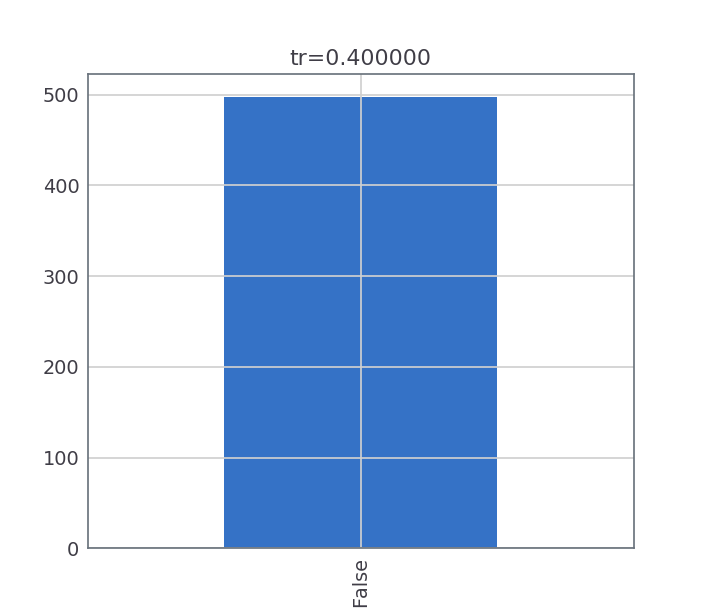

In [4]:
df_path = '/media/francesco/saetta/krock-dataset/train/csvs_patches/slope_rocks1-7.0-5.csv'
vis = DataFrameVisualization.from_path('/media/francesco/saetta/krock-dataset/train/csvs_patches/slope_rocks1-7.0-5.csv')
_ = vis.plot_advancement_box()
_ = vis.show_classes(0.4)


<IPython.core.display.Javascript object>


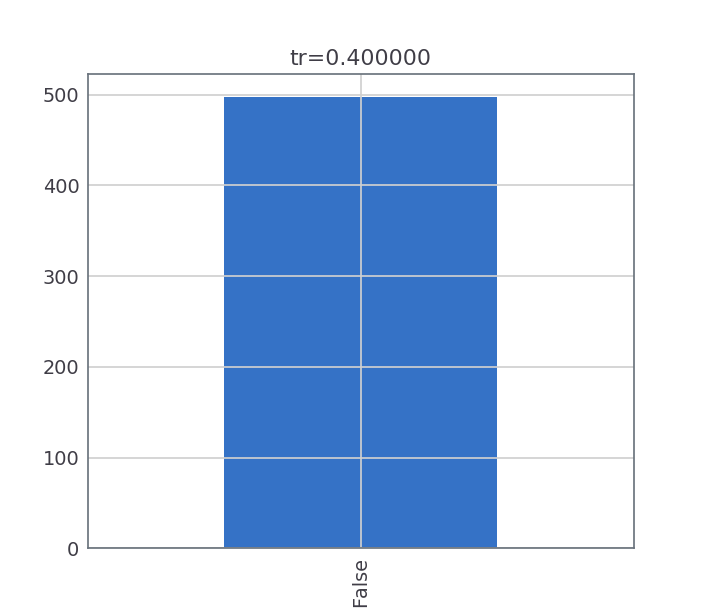

In [5]:
from utilities.postprocessing.utils import KrockPatchExtractStrategy
image_dir = '/media/francesco/saetta/krock-dataset/train/patches/'
vis = PatchesAndDataframeVisualization.from_df_path_and_hm_path(df_path, 
                                                                './maps/train/slope_rocks1.png',
                                                               max_advancement=0.66, 
                                                               image_dir=image_dir,
                                                               patch_extractor=KrockPatchExtractStrategy)


# _ = vis.show_patches()
_ = vis.show_classes(0.4)


In [30]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


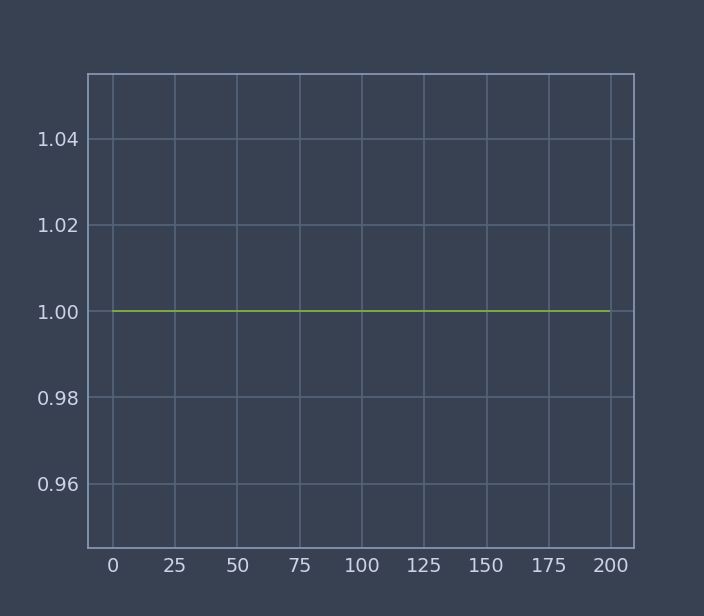

In [10]:
fig = plt.figure()
plt.plot(np.ones((200,200)))
fig.show()

## Find the correct treshold
In order to find a correct treshold to label the data, we first look at the mean advancement in the flat ground and then we half it to take into account slopes and ramps 

In [6]:
def find_tr(df):
    return df['advancement'].mean() / 2

In [7]:
from utilities.postprocessing.postprocessing import AddAdvancement
import pandas as pd
import glob 

seconds = np.arange(1, 5)
RATE = 50

def show_tr(seconds):
    dfs = [pd.read_csv(path) for path in glob.glob('/media/francesco/saetta/krock-dataset/flat/csvs_patches/*.csv')]
    window = RATE * seconds
    print('[INFO] window = {}'.format(window))
    add_adv = AddAdvancement(window)
    
    dfs = [add_adv((df, None, None))[0] for df in dfs]
    vis = DataFrameVisualization.from_dfs(dfs)
    vis.plot_advancement_box()
    print(vis.df['advancement'].mean())
    print(find_tr(vis.df))
    
interact(show_tr, seconds=seconds)

interactive(children=(Dropdown(description='seconds', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=…

<function __main__.show_tr(seconds)>

<IPython.core.display.Javascript object>


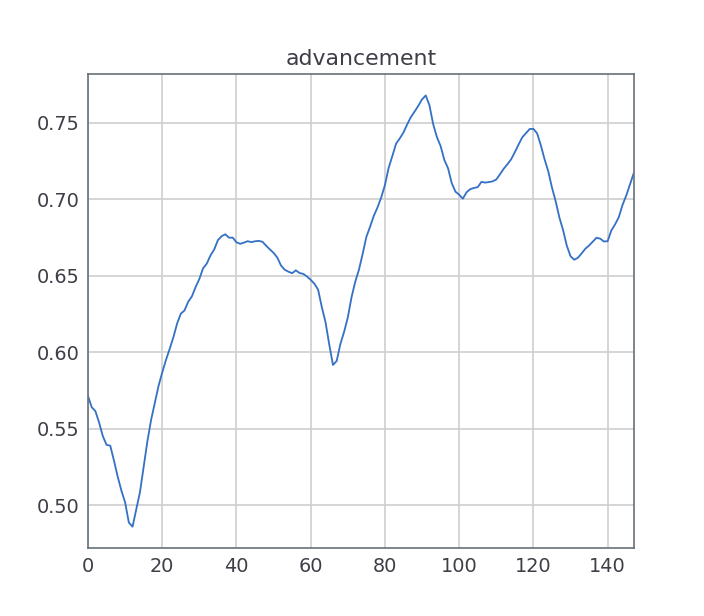

<IPython.core.display.Javascript object>


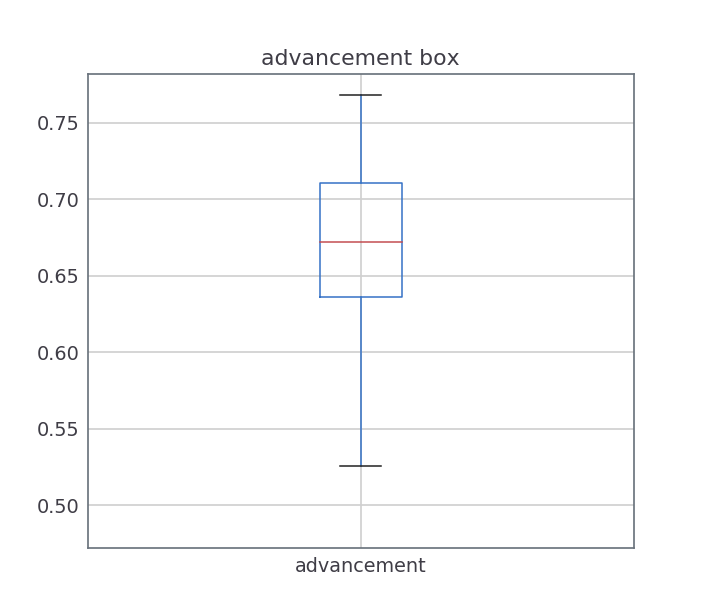

<IPython.core.display.Javascript object>


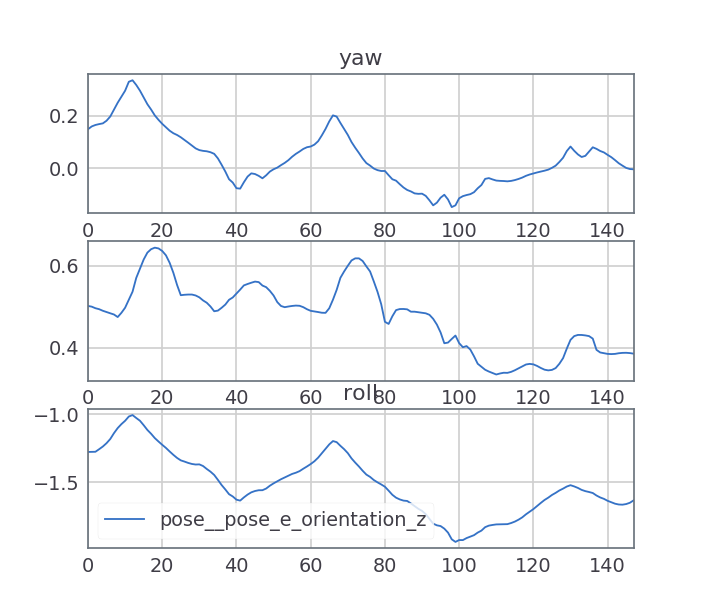

<IPython.core.display.Javascript object>


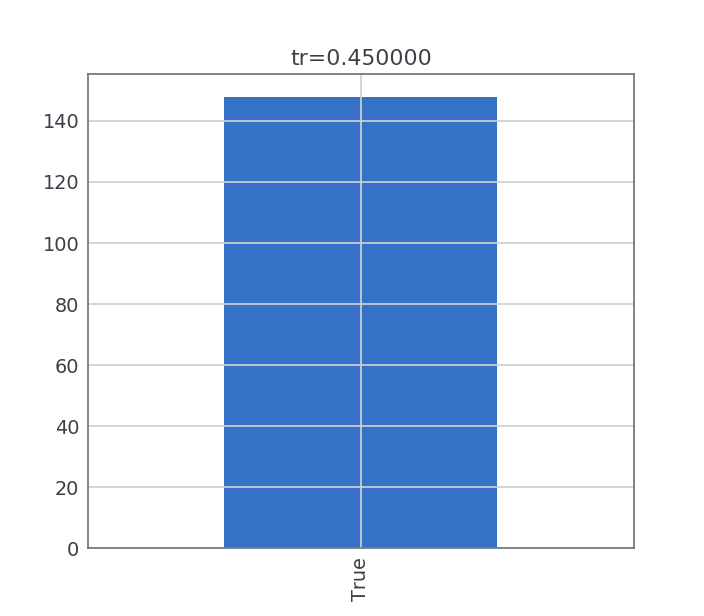

In [8]:
dfs = [pd.read_csv(path) for path in glob.glob('/media/francesco/saetta/krock-dataset/flat/csvs_patches/*.csv')]

df = AddAdvancement(50 * 3)((dfs[0], None, None))[0]
DataFrameVisualization(df)(tr=0.45)

In [11]:
flat_ground_vis = DataFrameVisualization.from_root('/media/francesco/saetta/krock-dataset/flat/csvs_patches/')

<IPython.core.display.Javascript object>


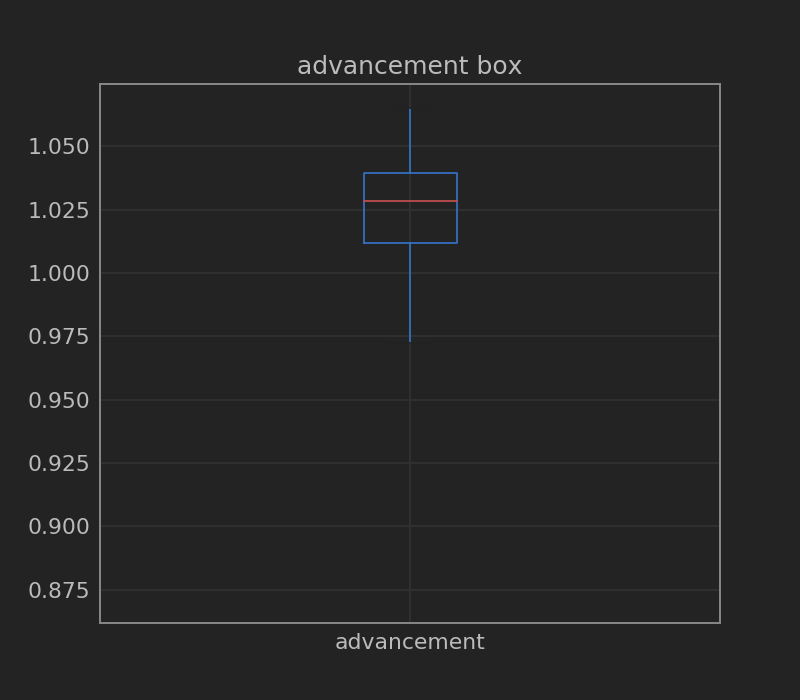

tr is 0.513


In [12]:
flat_ground_vis.plot_advancement_box()

tr = find_tr(flat_ground_vis.df)

print('tr is {:.3f}'.format(tr))

# Visualize the simulation
Visualize the robot's simulation on a specific map is tremendously useful to understand if everything went perfect. Also, we can have an idea about the generated dataset. 

We can start by plotting interestig stats for each dataset, train, val and test

In [4]:
TR = 0.2

In [5]:
DATASETS = ('/media/francesco/saetta/krock-dataset/train/', 
           '/media/francesco/saetta/krock-dataset/val/',
           '/media/francesco/saetta/krock-dataset/test/')

In [6]:
visualizations = [DataFrameVisualization.from_root(ds + '/csvs_patches') for ds in DATASETS]
visualizations = {'train' : visualizations[0], 'val' : visualizations[1], 'test': visualizations[2]}

## Train

<IPython.core.display.Javascript object>


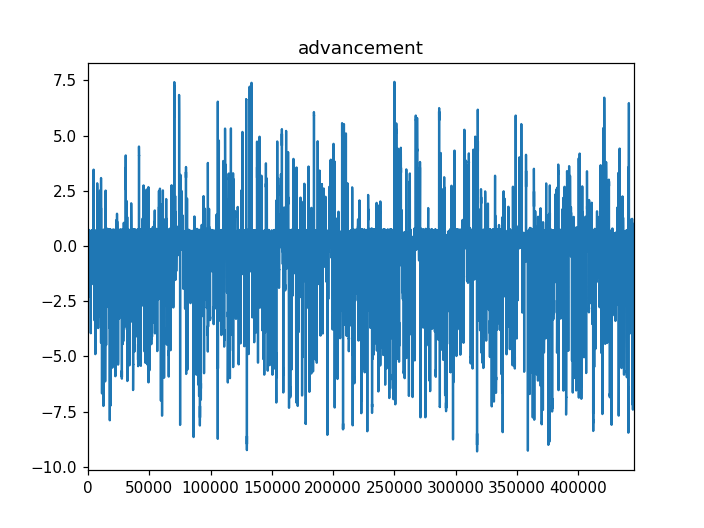

<IPython.core.display.Javascript object>


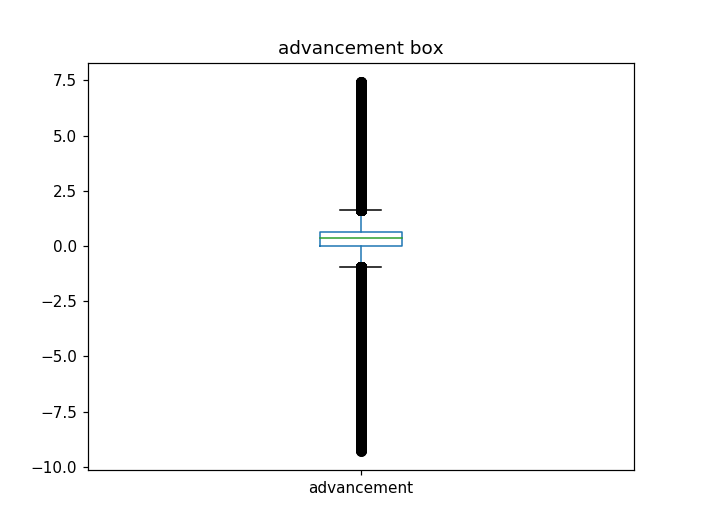

<IPython.core.display.Javascript object>


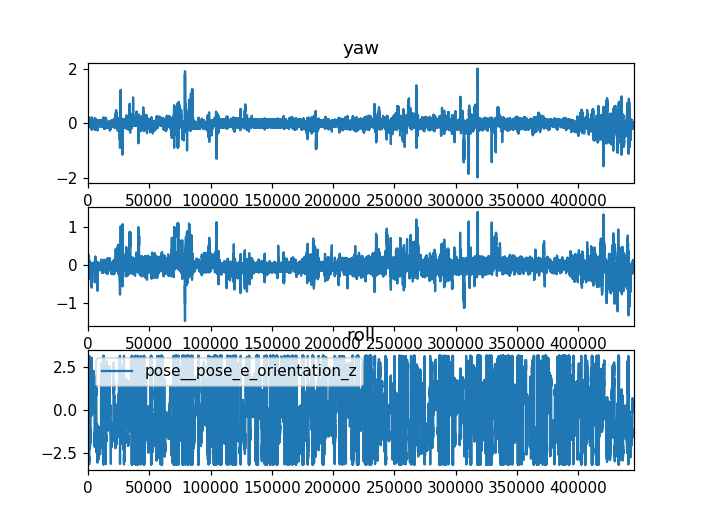

<IPython.core.display.Javascript object>


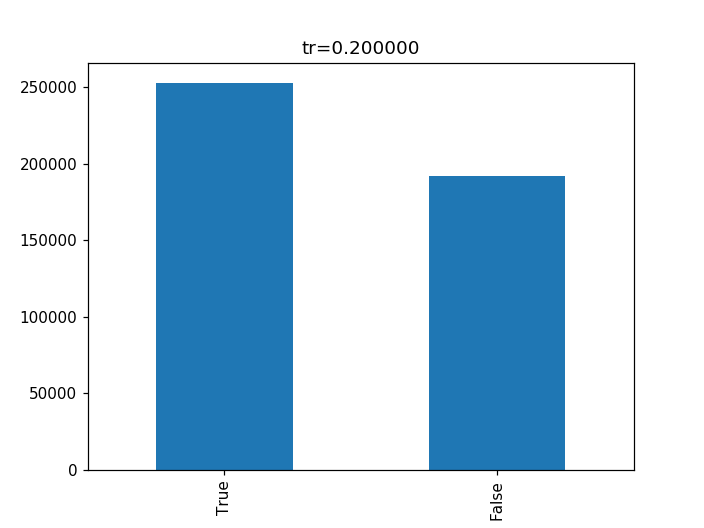

In [7]:
visualizations['train'](tr=TR, time_window=100)

In [13]:
visualizations['train'].show_classes(TR)
visualizations['train'].plot_advancement_box()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Val

<IPython.core.display.Javascript object>


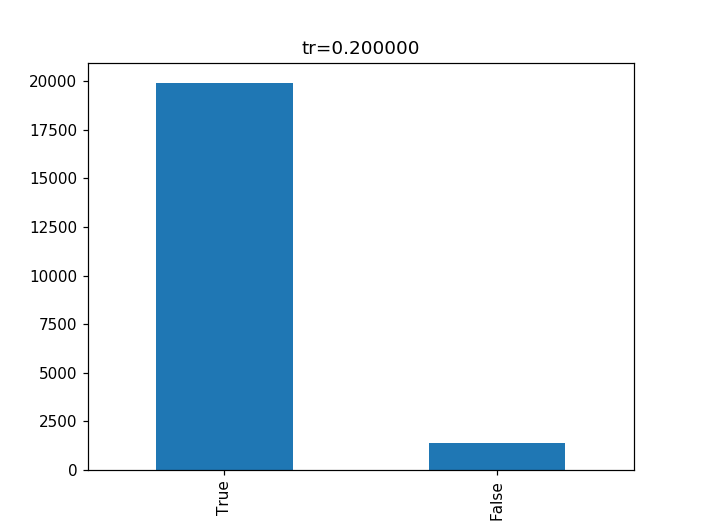

<IPython.core.display.Javascript object>


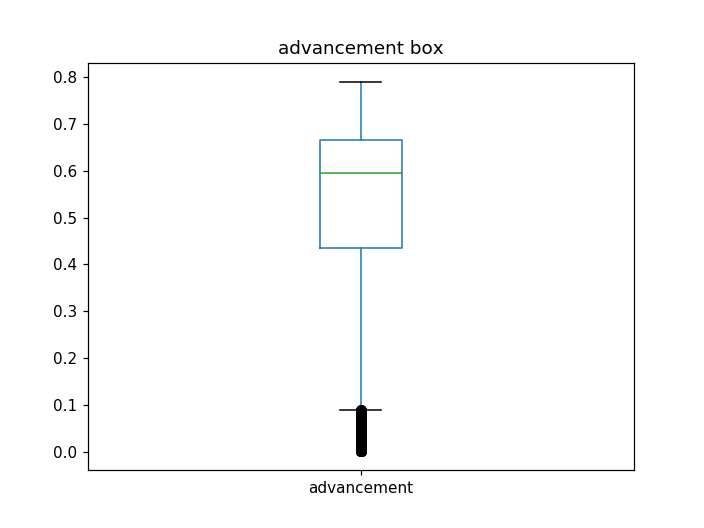

<IPython.core.display.Javascript object>


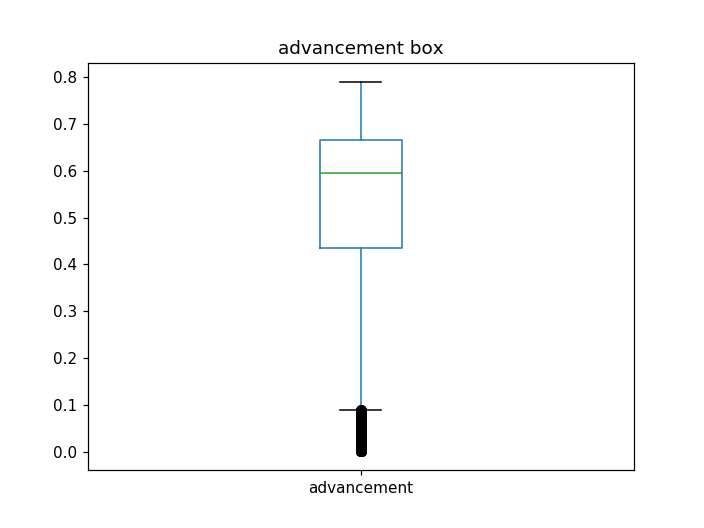

In [10]:
visualizations['val'].df = visualizations['val'].df[visualizations['val'].df['advancement'] > 0 ]
visualizations['val'].show_classes(TR)
visualizations['val'].plot_advancement_box()

## Test

<IPython.core.display.Javascript object>


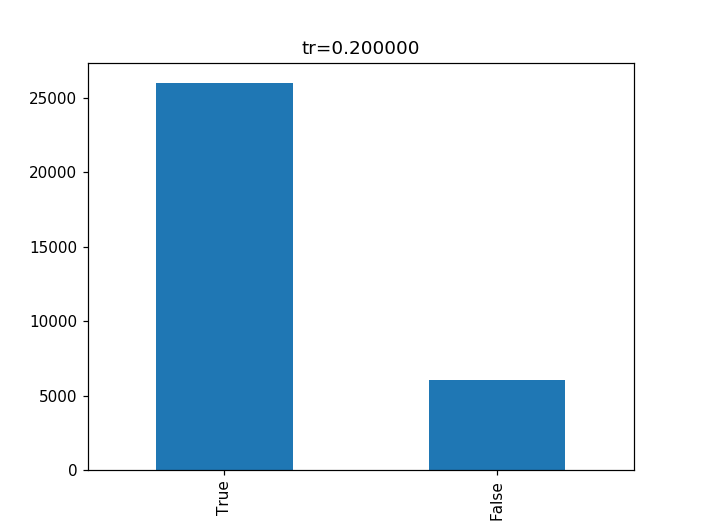

<IPython.core.display.Javascript object>


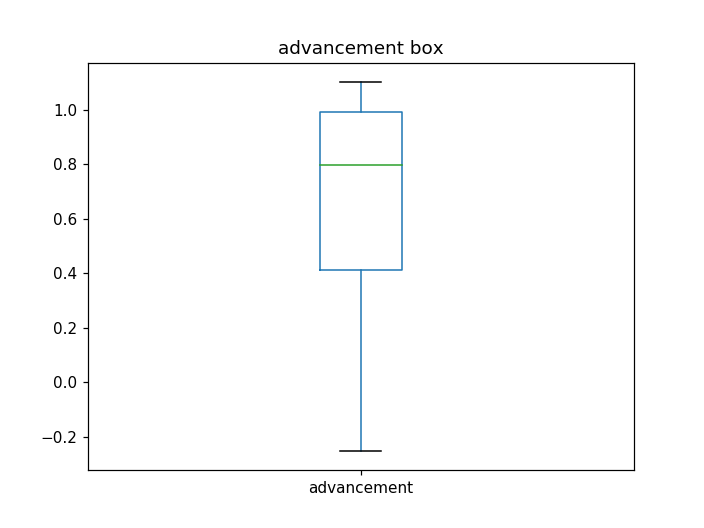

<IPython.core.display.Javascript object>


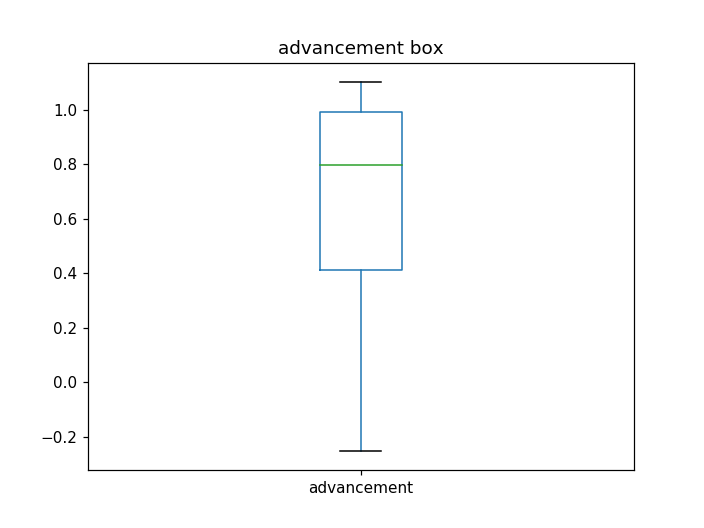

In [11]:
visualizations['test'].show_classes(TR)
visualizations['test'].plot_advancement_box()

### Classes Balance
We can also show different classes separation for different tr choices

In [ ]:
trs = np.arange(0.1,1,0.1)

def plot_classes_distribution(tr, mode):
    visualizations[mode].show_classes(tr)
    
    
interact(plot_classes_distribution, tr=trs, mode=['train', 'val', 'test'])


If we pick up a very permissive tr of 0.1 we can notice that the class balance is still very similar to the one with tr = 0.4/5. This means that most of the False cases are with tr close to 0.

### Patches

We can shows the robot traces and some patches for some specific simulations. This helps to debug the pipeline

In [ ]:
HM_DIR = '/home/francesco/Documents/Master-Thesis/core/maps/'

In [ ]:
tmp = PatchesAndDataframeVisualization.from_df_path('/media/francesco/saetta/quarry-ramp/from_flat_to_ramp/df/querry-big-10/1555314971.4928784-patch.csv', 
                                                    HM_DIR, 
                                                    image_dir='/media/francesco/saetta/quarry-ramp/from_flat_to_ramp')

In [ ]:
tmp.show_classes(tr=TR)
tmp.show_patches_on_the_map()

In [ ]:
bars1_vis = PatchesAndDataframeVisualization.from_df_path('/media/francesco/saetta/no-shift-88-750/train/df/bars1/1550615138.5778086-patch.csv',
                                                         HM_DIR,
                                                         image_dir='/media/francesco/saetta/no-shift-88-750/train')

In [ ]:
bars1_vis.show_patches_on_the_map()

In [ ]:
bars1_vis.show_patches()

In [7]:
import pandas as pd
import cv2

In [21]:
meta = pd.read_csv('/media/francesco/saetta/krock-dataset/train/bags/meta.csv')

In [22]:
# meta = meta.drop(meta[(meta['map'] == 'slope_rocks1') & (meta['height'] == 1)].index)
# meta = meta[meta['height'] == 1]
meta = meta[meta['map'] == 'bars1']

dfs = [pd.read_csv('/media/francesco/saetta/krock-dataset/train/csvs_patches/{}.csv'.format(name))
      for name in meta['filename']]

meta

,Unnamed: 0,filename,map,height
350,350,bars1-1.0-0,bars1,1.0
351,351,bars1-1.0-1,bars1,1.0
352,352,bars1-1.0-2,bars1,1.0
353,353,bars1-1.0-3,bars1,1.0
354,354,bars1-1.0-4,bars1,1.0
355,355,bars1-1.0-5,bars1,1.0
356,356,bars1-1.0-6,bars1,1.0
357,357,bars1-1.0-7,bars1,1.0
358,358,bars1-1.0-8,bars1,1.0
359,359,bars1-1.0-9,bars1,1.0


<IPython.core.display.Javascript object>


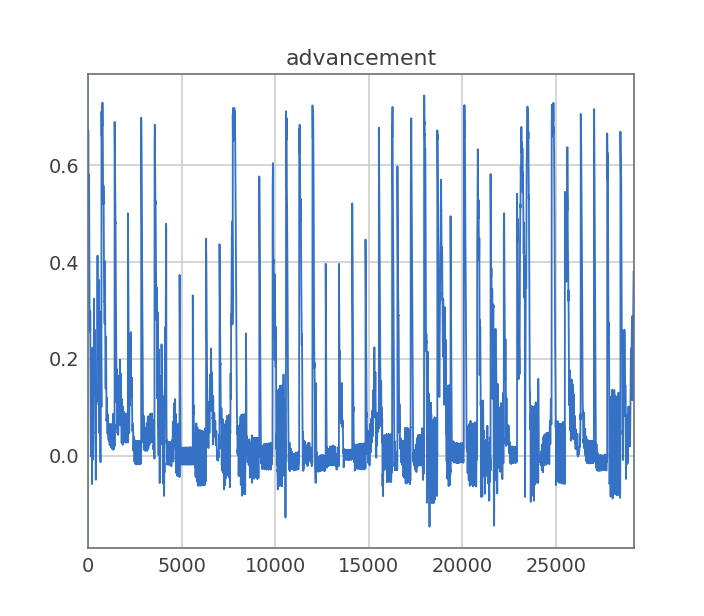

<IPython.core.display.Javascript object>


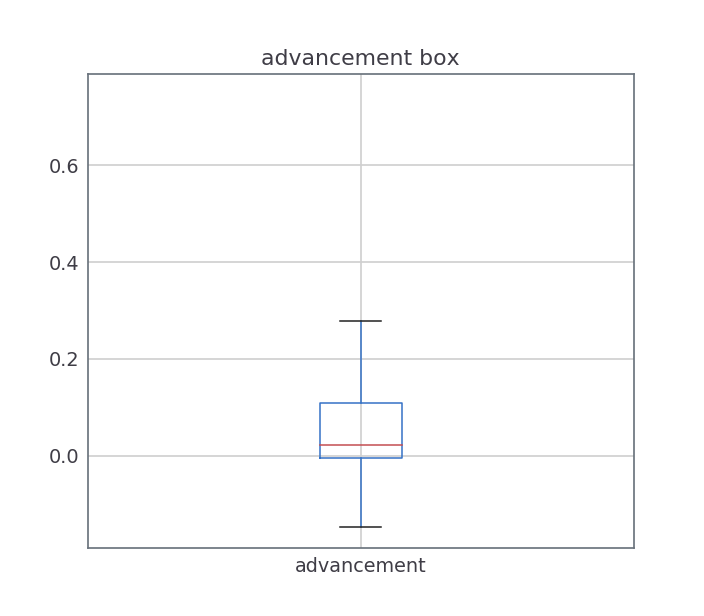

<IPython.core.display.Javascript object>


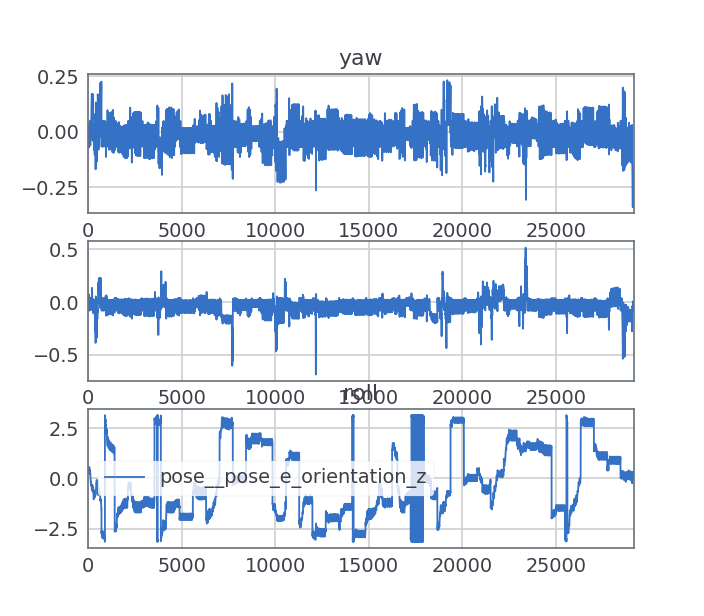

<IPython.core.display.Javascript object>


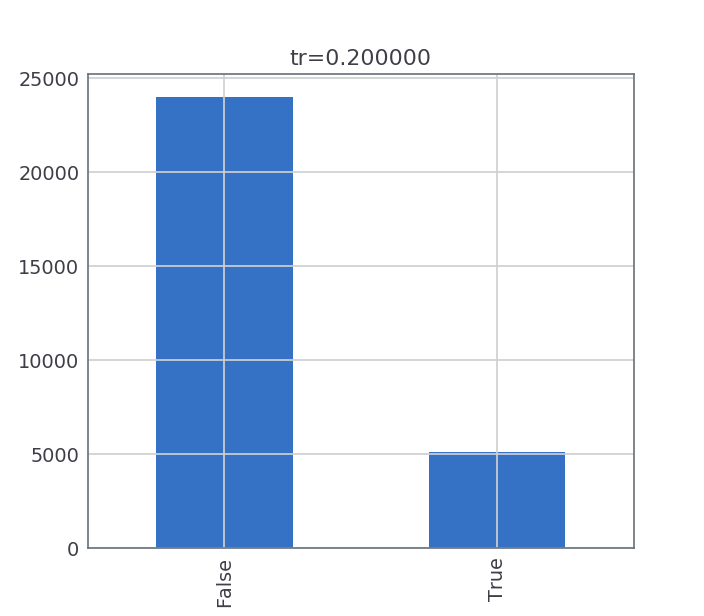

In [23]:
add_adv = AddAdvancement(100)

dfs = [add_adv((df, None, None))[0] for df in dfs]
vis = DataFrameVisualization.from_dfs(dfs)(0.2)

<IPython.core.display.Javascript object>


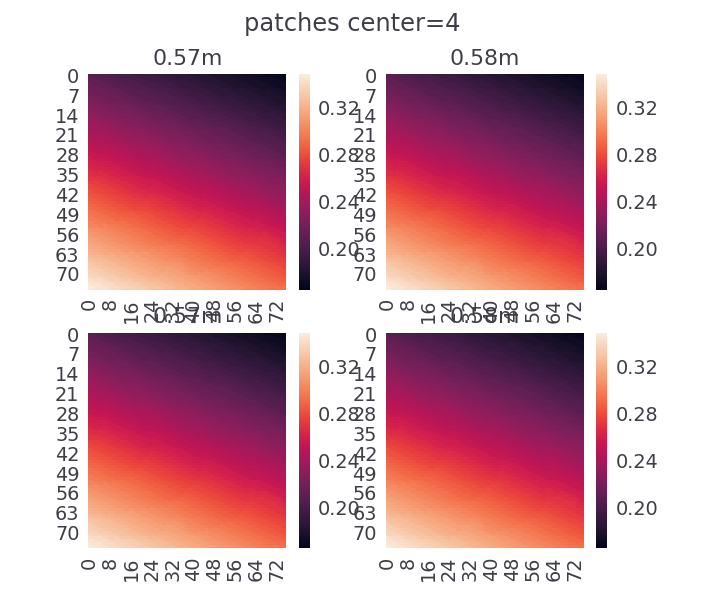

<IPython.core.display.Javascript object>

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:

hm = cv2.imread('./maps/train/slope_rocks1.png')
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

vis = PatchesAndDataframeVisualization(dfs[0], hm, 0.66, patch_extractor=KrockPatchExtractStrategy)
vis.show_patches(4, disable_patch_axis=False)
vis.show_traces([dfs[0]])
vis.show_patches_on_the_map()
vis.show_labeled_patches(0.45)

In [23]:
??PatchesAndDataframeVisualization

<IPython.core.display.Javascript object>


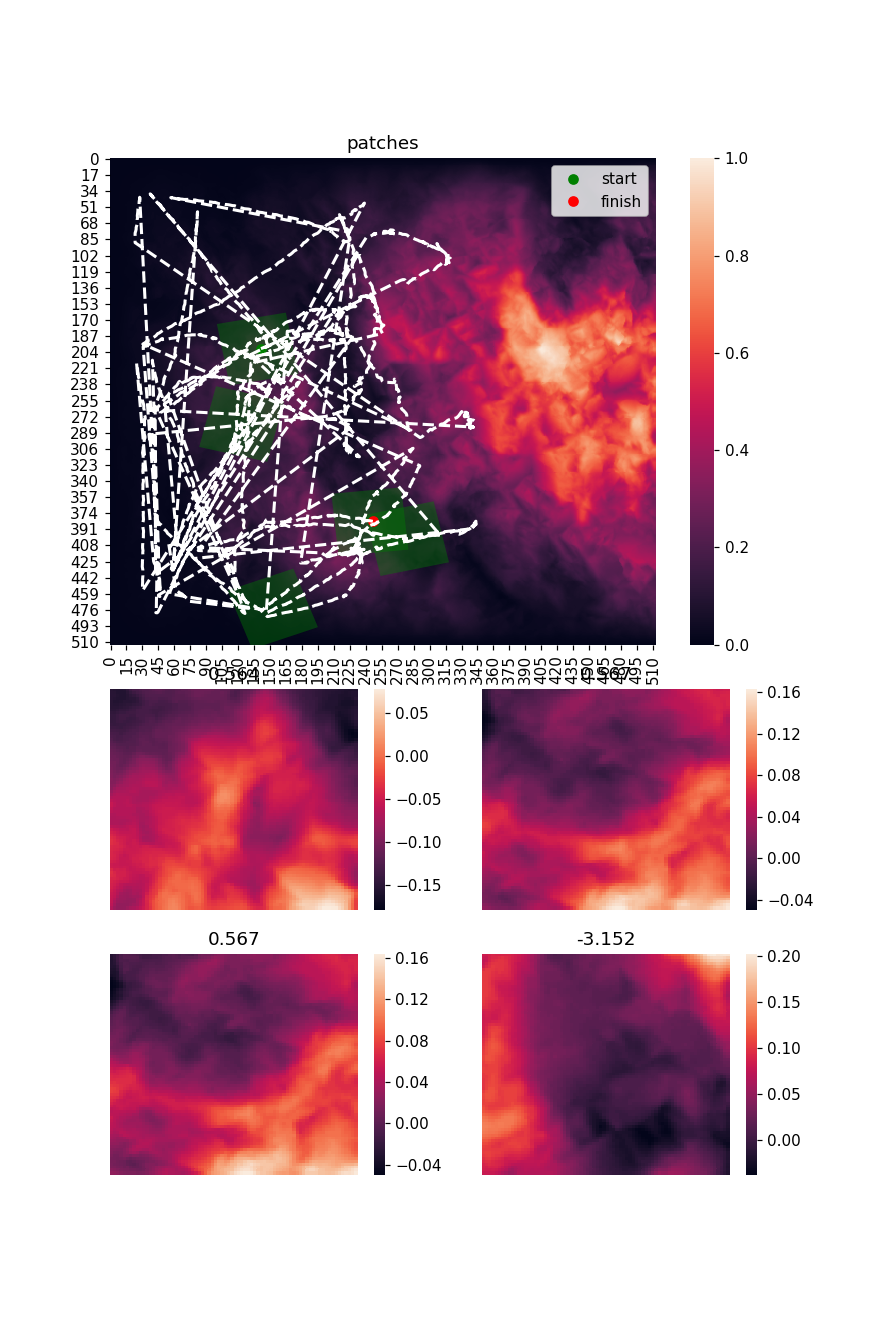

In [41]:
import cv2
hm = cv2.imread('./maps/val/arc_rocks.png')
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)
vis = PatchesAndDataframeVisualization.from_root('/media/francesco/saetta/krock-dataset/val/csvs_patches/', 
                                                 hm=hm,
                                                 max_advancement=0.66,
                                                time_window=100)
                                                 

_ = vis.show_patches_on_the_map()


In [25]:
DataFrameVisualization(dfs[0])(0.45)

NameError: name 'dfs' is not defined

In [205]:
??PatchesAndDataframeVisualization

In [14]:
import rosbag
from utilities.postprocessing.postprocessing import *

name = meta[meta['map'] == 'bars1']['filename'].iloc[0]
df = pd.read_csv('/media/francesco/saetta/krock-dataset/train/csvs_patches/{}.csv'.format(name))
hm = cv2.imread('./maps/train/bars1.png')
hm = cv2.cvtColor(hm, cv2.COLOR_BGR2GRAY)

# vis = PatchesAndDataframeVisualization.from_root('/home/francesco/Desktop/querry-down-hill/csvs_patches', hm)

# vis(0.45)
# vis.show_traces([vis.df])
# vis.show_patches_on_the_map()

vis = PatchesAndDataframeVisualization(df, hm, patch_size=66)
vis.show_traces([vis.df])
vis.show_patches()

NameError: name 'meta' is not defined

In [17]:
x, y, alpha = vis.df['hm_x'][0], vis.df['hm_y'][0], np.rad2deg(vis.df['pose__pose_e_orientation_z'][0])